# Ergonomics Bidirectional RNN

The main approach here is to generate a baseline bidirectional rnn model based on the example from an activity recognition dataset. The main approach is to produce a sequence of sequential poses
and classify the class of the pose using information from the past and the future. Input will be defined as:
$X_{seq}$ and $Y_{seq}$. The dimensionality of $X$ and $Y$ are [$N$, $F$, $K$] for $N$ batch samples, $F$ frames and $K$ features.

In [1]:
from torch import nn
import pytorch_lightning as pl
import torch.nn.functional as F

class ErgnomicsActivityClassifier(pl.LightningModule):
      FEATURE_DROPOUT_RATE = 0.2
      TEMPORAL_DROPOUT_RATE = 0.2

      # initialise method
      def __init__(self, input_features, hidden_dim, n_classes, lr):
            super().__init__()
            # bidirectional lstm layers
            self.lstm_layer_1 = nn.LSTM(input_features, hidden_dim, bidirectional=True, batch_first=True)
            self.lstm_layer_2 = nn.LSTM(2*hidden_dim, hidden_dim, bidirectional=True, batch_first=True)
            # linear layers
            self.linear_layer_1 = nn.Linear(2*hidden_dim, hidden_dim)
            self.linear_layer_2 = nn.Linear(hidden_dim, hidden_dim//2)
            self.linear_layer_3 = nn.Linear(hidden_dim//2, n_classes)
            # activations
            self.relu = nn.ReLU()
            self.softmax = nn.Softmax(dim=2)
            # regularization
            self.feature_dropout = nn.Dropout(p=self.FEATURE_DROPOUT_RATE)
            self.learning_rate = lr


      def forward(self, x):
            # feature dropout
            #TODO add guassian noise
            x = self.feature_dropout(x)
            x, (hidden_state, cell_state) = self.lstm_layer_1(x)
            x, (hidden_state, cell_state) = self.lstm_layer_2(x)
            x = self.linear_layer_1(x)
            x = self.relu(x)
            x = self.linear_layer_2(x)
            x = self.relu(x)
            x = self.linear_layer_3(x)
            x = self.softmax(x)
            # invoke linear layer
            return x
      
      def training_step(self, batch, batch_index):
            x, y = batch
            y_hat = self(x)
            loss = torch.nn.BCELoss()(y_hat, y)
            self.log("training_loss", loss)
            return loss

      def validation_step(self, batch, batch_index):
            x, y = batch
            y_hat = self(x)
            loss = torch.nn.BCELoss()(y_hat, y)
            self.log("validation_loss", loss)

            return loss
      
      def configure_optimizers(self):
            return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [2]:
# instantiate model
import torch
batch_size = 10
window = 15
features = 34
x_sequence = torch.rand(batch_size, window, features)

In [3]:
x_sequence.size()

torch.Size([10, 15, 34])

In [4]:
network = ErgnomicsActivityClassifier(features, hidden_dim =100, n_classes =3 , lr=0.001)

In [5]:
out = network(x_sequence)

In [6]:
# create dummy loss

loss = nn.BCELoss()
y_sequence = torch.rand(batch_size, window, 3).softmax(dim=2)


print(y_sequence.size())
print(out.size())
l = loss(out, y_sequence)
l.backward()

torch.Size([10, 15, 3])
torch.Size([10, 15, 3])


# Example Dataset

The example dataset is coming from this project:
https://github.com/stuarteiffert/RNN-for-Human-Activity-Recognition-using-2D-Pose-Input#dataset-overview

They are internally using open pose applied to this dataset:
http://tele-immersion.citris-uc.org/berkeley_mhad

In [7]:
#NOTE: this is adapted from https://github.com/stuarteiffert/RNN-for-Human-Activity-Recognition-using-2D-Pose-Input#dataset-overview
# Useful Constants

# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 
DATASET_PATH = "/home/tim_voxelai_com/data/example/RNN-HAR-2D-Pose-database/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

n_steps = 32 # 32 timesteps per series

# Load the networks inputs

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    y_ = y_ - 1
    y_ = y_* np.ones((n_steps))
    return y_

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

Now to test, we can just generate a training loop using this training and testing data


In [8]:
print(X_train.shape)
print(y_train.shape)

(22625, 32, 36)
(22625, 32)


In [9]:
# dataloaders
from torch.utils.data import DataLoader


class SampleDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.length = x.shape[0]
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        return self.x[index, :, :], torch.nn.functional.one_hot(torch.tensor(self.y[index, :]).long(), num_classes=len(LABELS)).float()


train_dataset = SampleDataset(X_train, y_train)
test_dataset = SampleDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset,  batch_size=512, shuffle=True)

In [10]:
from pytorch_lightning import Trainer
# Try creating a model
import wandb

# configure wandb

def setup_wandb():
    wandb.init(project='activity_recognition_mhad', entity='voxel-wandb', sync_tensorboard=True)
setup_wandb()

samples, window_size, n_features = X_train.shape
sample_model = ErgnomicsActivityClassifier(input_features=n_features, hidden_dim=50, n_classes=len(LABELS), lr=0.001)
trainer = Trainer(gpus=1, min_epochs=100, max_epochs=100)
trainer.fit(sample_model, train_dataloader, test_dataloader)

wandb: Currently logged in as: voxel-wandb (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.17 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-06-01 14:12:56.036867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 14:12:56.036914: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type    | Params
--------------------------------------------
0 | lstm_layer_1    | LSTM    | 35.2 K
1 | lstm_layer_2    | LSTM    | 60.8 K
2 | linear_layer_1  | Linear  | 5.0 K 
3 | linear_layer_2  | Linear  | 1.3 K 
4 | linear_layer_3  | Linear  | 156   
5 | relu            | ReLU    | 0     
6 | softmax         | Softmax | 0     
7 | feature_dropout | Dropout | 0     
--------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.410     Total estimated model params size (MB)


/home/tim_voxelai_com/.cache/bazel/_bazel_tim_voxelai_com/1ca15b1c532eb7ff315d325e54dc47fe/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_pytorch_lightning/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/home/tim_voxelai_com/.cache/bazel/_bazel_tim_voxelai_com/1ca15b1c532eb7ff315d325e54dc47fe/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_pytorch_lightning/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/tim_vox

In [11]:
# compute accuracy metrics
true_labels = []
predicted_labels = []
for xi_test, yi_test in test_dataset:
    # evaluate on model
    x = torch.tensor([xi_test])
    y_hat = sample_model(x)
    # get argmax
    
    predictions = torch.argmax(y_hat[0], dim=1)
    ground_truth = torch.argmax(yi_test, dim=1) 
    # get accuracy:
    true_labels.extend(ground_truth)
    predicted_labels.extend(predictions)

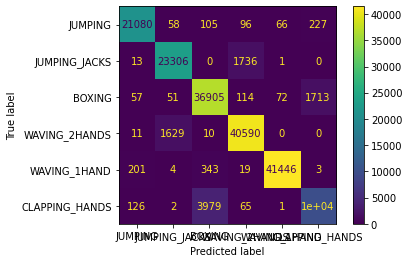

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix(true_labels, predicted_labels), display_labels=LABELS)
import matplotlib.pyplot as plt
disp.plot()
plt.show()

In [13]:
import sklearn
print(sklearn.metrics.classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     21632
           1       0.93      0.93      0.93     25056
           2       0.89      0.95      0.92     38912
           3       0.95      0.96      0.96     42240
           4       1.00      0.99      0.99     42016
           5       0.84      0.71      0.77     14176

    accuracy                           0.94    184032
   macro avg       0.93      0.92      0.92    184032
weighted avg       0.94      0.94      0.94    184032

